## ESoWC 2019: Data-driven feature selection towards improving forecast-based prediction of wildfire hazard

Team: [@mariajoaosousa](https://github.com/mariajoaosousa), [@eduardogfma](https://github.com/eduardogfma)

Project github page: [https://github.com/esowc/ml_fire](https://github.com/esowc/ml_fire)

# Support Vector Machine I

This is the 1st of 3 notebooks in which the necessary conditions to model the relationship between FWI and a set of different features are investigated. To do so, the methodology is based on the Support Vector Machine (SVM) framework, in which the features used to train the model are incrementally input. The reason for this incremental approach is two fold: (1) control the modelling process, and (2) gain insights about the system and its components' symbiotic relationships.

Recall (from [Tutorial 1](https://github.com/esowc/ml_fire/blob/master/GettingStartedWithData/Tutorial01-GettingStartedWithData_FWI.ipynb)) that the FWI is computed as a function with two arguments:  ISI and BUI, as shown in Figure 1.

![](https://camo.githubusercontent.com/f9525fe4c85b25cfd4369b56465eca39f12dd1e6/68747470733a2f2f63776669732e6366732e6e7263616e2e67632e63612f696d616765732f6677695f7374727563747572652e676966)

As a first step, one is interested in ascertain SVM is a framework capable of capturing the relationships between features and labels. Thus, this notebook investigates which methods exist that that would enable one to predict FWI, knowing BUI and ISI. Moreover, we are interested in using spatial dependencies, i.e. knowing the BUI and ISI values for a particular geographical region (e.g. a country) how accurate is the FWI prediction. The fundamental question of this notebook is the following:

> Is it possible to predict *FWI*, knowing *BUI* and *ISI* for all geographical locations, for a particular time sample (in this case, a day)?

## Introduction

“Support Vector Machine” (SVM) is a supervised machine learning algorithm mainly used for classification problems. However, it can also be used to tackle regression problems. When dealing with classification challenges, the SVM is inted to work as linear classifier, i.e. provided a set of different points it should be able to determine the *boundary* that separates points belonging to different classes.

More formally,  in SVMs any data point is viewed as a $n$-dimensional vector, and the goal is to determine the $(n-1)$-dimensional *hyperplane* that sets the boundary between points of different classes. Consider the example of Figure 2. Since there exists a multitude of ways to separate blue, from green points, the problem then consists on determining the *best line* (since a hyperplane is represented by a line in 2D) that separates points belonging to different classes.

To find the *best* hyperplane, the intuition is that the best hyperplane is the one that maximises the separation, or *margin* (yellow area in Figure 1), between the two classes.

![](https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png)

Figure 2 -- 2D SVM classification problem (based on [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Linear_SVM)).

Using the concept of margin, the method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression (SVR). Contrary to simple regression, where the goal consists in mnimising the error rate. In SVR the goal is to maintain the error within a well defined boundary, where this boundary is the *margin*, as shown in Figure 3.

![](https://www.saedsayad.com/images/SVR_1.png)

Figure 3 -- 2D SVM regression problem (based on [Saed Sayad](https://www.saedsayad.com/support_vector_machine_reg.htm)).

Note that in both cases (classification and regression) the main idea is the same: to determine the hyperplane which maximizes the margin, keeping in mind that some degree of error toleration is employed. Because of this notion of *error tolerance*, the produced model depends only on a subset of the training data. In classification, points from the training dataset that lie beyond the margin are disregarded. In regression,  training data close to the model prediction is ignored.



### Online (incremental) learning algorithms

One particular disadvantage of SVM is that it commonly makes use of static models, i.e. models that can not learn incrementally. This means that each model requires all training to be processed at once. Some points must be noted here. First, depending on the problem and the available training set, this may not not be computationally feasible since the training process requires all trainig data to be in memory at once. Second, once trained, the model can not improve its performance with experience. Each time one wants to improve the model's performance, a new training process must be employed, in which the a *new set of parameters* is computed, throwing away the old one.

To mitigate this, various incremental SVM approaches have been devised. (For a list of these methods please refer to the following [link](http://www.quora.com/Support-Vector-Machines/What-are-some-good-tools-for-training-online-svm).) In terms of implementation, however, online SVM methods tend to be developed in C/C++. 

Since this project is intended to be developed entirely in python, one can resort to the scikit learn's [Stochastic Gradient Descent (SGD)](https://scikit-learn.org/stable/modules/sgd.html). SGD is a class of linear prediction methods related to online algorithms such as perceptron [[1]](https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=2A8BC2B2E9E64B559C6C6EEEE396F486?doi=10.1.1.58.7377&rep=rep1&type=pdf) and is widely used to solve SVM regression problems, due to its efficiency, and ease of implementation [[2]](https://scikit-learn.org/stable/modules/sgd.html#regression). For more information on SGD and SVM, the interested reader is referred to the following section, where he/she may find thses topics covered in various levels of expertise.
___

_**Further reading:**_

> **Theory:**
>> **SVM:**
* https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72
* https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-034-artificial-intelligence-fall-2010/tutorials/MIT6_034F10_tutor05.pdf

>> **SVR:**
* https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html
* https://alex.smola.org/papers/2003/SmoSch03b.pdf

>> **Online models:**
* [“Solving large scale linear prediction problems using stochastic gradient descent algorithms”](https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=2A8BC2B2E9E64B559C6C6EEEE396F486?doi=10.1.1.58.7377&rep=rep1&type=pdf) T. Zhang - In Proceedings of ICML ‘04.

## Runtime and environment setup

In [0]:
!pip install netcdf4
!pip install ipython-autotime  # link: https://stackoverflow.com/a/36690084

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports and raw data loading

In [0]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autotime

In [0]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.signal import savgol_filter

time: 442 ms


In [0]:
rawData ={}
rawData["fwi"] = xr.open_dataset("../content/gdrive/My Drive/ESoWC/datasets/segmented_data/GADM/fwiCAN_GADM00.nc")
rawData["isi"] = xr.open_dataset("../content/gdrive/My Drive/ESoWC/datasets/segmented_data/GADM/isiCAN_GADM00.nc")
rawData["bui"] = xr.open_dataset("../content/gdrive/My Drive/ESoWC/datasets/segmented_data/GADM/buiCAN_GADM00.nc")

time: 79.6 ms


In [0]:
scaler = StandardScaler()  # prepare for data regularization

time: 1.81 ms


In [0]:
seed1 = np.random.RandomState(100)
seed2 = np.random.RandomState(100)

time: 1.54 ms


## Data partitioning

For each dataset, split in Tain and Test datasets.

### *Handling functions*

In [0]:
def getRandomIndex(indexList, train=1):
  '''
    Gets random index.
    
      indexList: ..................... [list] list of indeces
      train: ......................... [int] 1 for train, 0 for test
      
      > output: [int] random index
      
      Given a list of indeces, the function returns a random element of that
      list.
  '''
  n = len(indexList)
  if(train == 1):
    ind = seed1.randint(0,n)
  else:
    ind = seed2.randint(0,n)
  return indexList.pop(ind)

time: 10.2 ms


In [0]:
def getData(data, index):
  '''
    Gets data and fills 'nan' with 0 (zero).
    
      data: ................ [xarray.DataSet] raw data corresponding to 
                                              a feature, over time
      index: ............... [int] index
      
      > output: [numpy.array] array containing the data of a particular day
      
      Given a xarray.DataSet and an index, the function returns the data 
      corresponding to the day corresponding to the index provided. Furthermore,
      all 'nan' values are substituted by 0 (zero).
  '''
  return data[index].fillna(0).values

time: 1.37 ms


In [0]:
def getRandomData(indexList, train=1):
  '''
    Gets radom data, where 'nan' values are replaced by zeros.
    
      indexList: ..................... [list] list of indeces
      train: ......................... [int] 1 for train, 0 for test
      
      > output: [numpy.array] features of interest
      
      Given a list of indeces, the function returns the data of the features of 
      interest, (i.e fwi, bui, isi) where 'nan' values are replaced by zeros.
  '''
  i = getRandomIndex(indexList, train)
  fwi = getData(rawData['fwi']['fwi'], i)
  bui = getData(rawData['bui']['bui'], i)
  isi = getData(rawData['isi']['isi'], i)
  return fwi, bui, isi

time: 8.23 ms


In [0]:
def standardize(x, y, train=1):
  # x - x.mean / x.std
  data = np.concatenate((x,y),axis=1)
  #data = (data - data.mean()) / data.std()
  
  if(train==1):
    scaler.fit(data)
    
  data = scaler.transform(data)
  return data[:,0:2],data[:,2:3]

time: 9.23 ms


### Train and Test datasets

In [0]:
# get dimension of vectorized loocations
dim = rawData['fwi']['fwi'][0].shape[0]*rawData['fwi']['fwi'][0].shape[1]

time: 6.37 ms


In [0]:
# define data
# since all xarray.DataSet have the same dimensions, it suffices to consider
# one of the 3 (fwi, bui, or isi)
data = rawData['fwi']['fwi']

# get train and test indexes
for train_index, test_index in KFold(n_splits=3, random_state=0).split(data):
  print("TRAIN:", train_index, "TEST:", test_index)
  train_index = list(train_index)
  test_index = list(test_index)
  break

TRAIN: [ 4687  4688  4689 ... 14058 14059 14060] TEST: [   0    1    2 ... 4684 4685 4686]
time: 15.1 ms


In [0]:
# get data randomly
fwi, bui, isi = getRandomData(train_index, train=1)

# reshape
fwi = np.reshape(fwi,(dim,1))
bui = np.reshape(bui,(dim,1))
isi = np.reshape(isi,(dim,1))

# build X and y
X = np.concatenate((bui,isi),axis=1)
y = fwi

# data standardization
X, y = standardize(X, y, train=1)

time: 32.2 ms


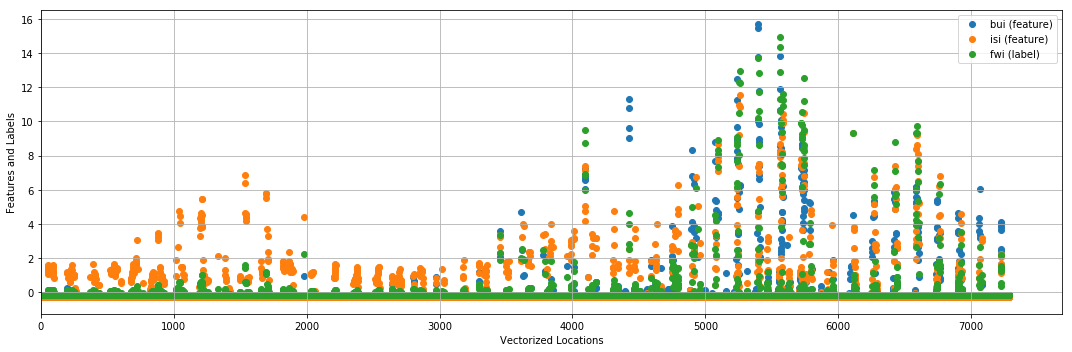

time: 965 ms


In [0]:
# see all data points

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(0,len(X[:,0])), X[:,0], label="bui (feature)")
plt.scatter(np.arange(0,len(X[:,0])), X[:,1], label="isi (feature)")
plt.scatter(np.arange(0,len(X[:,0])), y, label="fwi (label)")
plt.xlim(0)
#plt.ylim(0)
plt.xlabel("Vectorized Locations")
plt.ylabel("Features and Labels")
plt.grid()
plt.legend()

plt.tight_layout()

## Model

In [0]:
model = linear_model.SGDRegressor(
    loss="epsilon_insensitive",
    shuffle=False,
    epsilon=1e-2, 
    max_iter=1e4, 
    tol=1e-4)

i = 1
train_elements = -1  # -1 => use all test dataset

if(train_elements==-1):
  print("Number of train elements used: ", len(train_index), "of", len(train_index))
else:
  print("Number of train elements used: ", train_elements, "of", len(train_index))

score = []
while(train_index):
  # get data randomly
  fwi, bui, isi = getRandomData(train_index, train=1)

  # reshape
  fwi = np.reshape(fwi,(dim,1))
  bui = np.reshape(bui,(dim,1))
  isi = np.reshape(isi,(dim,1))

  # build X and y
  X = np.concatenate((bui,isi),axis=1)
  y = fwi

  # data standardization
  X, y = standardize(X, y, train=1)

  ## data normalization
  #X, y = normalize(X, y)

  model = model.fit(X, np.ravel(y))
  
  if(i==train_elements):
    break
    
  i+=1

Number of train elements used:  9373 of 9373
time: 2min 7s


## Preliminary assessment

In the following code cells, an SVR model is trained on a single `xarray.DataArray` for each feature. The model's performance is then assessed based on a qualitative basis, i.e. by graphical inspection.

This is an important evaluation, since it provides information about which methodology to follow. If the model does not perform well, the methodology must be reviewed and data preprocessing must be different.

In [0]:
# Model Info
print("Score:", np.round(model.score(X, y),2)*100, "%")
print("Parameters:", model.get_params())

Score: 96.0 %
Parameters: {'alpha': 0.0001, 'average': False, 'early_stopping': False, 'epsilon': 0.01, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'epsilon_insensitive', 'max_iter': 10000.0, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': False, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
time: 12.9 ms


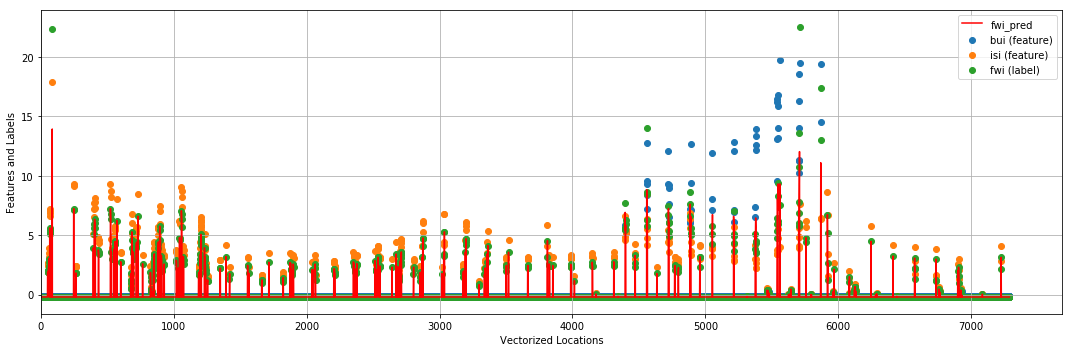

time: 977 ms


In [0]:
# fit to the data used to train
plt.figure(figsize=(15, 5))
plt.scatter(np.arange(0,len(X[:,0])), X[:,0], label="bui (feature)")
plt.scatter(np.arange(0,len(X[:,0])), X[:,1], label="isi (feature)")
plt.scatter(np.arange(0,len(X[:,0])), y, label="fwi (label)")
plt.plot(model.predict(X), color='red', label="fwi_pred")
plt.xlim(0)
#plt.ylim(0)
plt.xlabel("Vectorized Locations")
plt.ylabel("Features and Labels")
plt.grid()
plt.legend()

plt.tight_layout()

As shown above, the model was able to effectively capture the nonlinear dinamics between the features and label ([score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor.score) = 96%). The question now, is "Can the model generalize?", i.e. how good are predictions based on unseen data.

The following cells test the model performance.

## Testing

In [0]:
i = 1
test_elements = -1  # -1 => use all test dataset

if(test_elements==-1):
  print("Number of train elements used: ", len(test_index), "of", len(test_index))
else:
  print("Number of train elements used: ", len(test_index), "of", len(test_index))

score = []
while(test_index):
  # get data randomly
  fwi, bui, isi = getRandomData(test_index, train=0)
  
  # reshape
  fwi = np.reshape(fwi,(dim,1))
  bui = np.reshape(bui,(dim,1))
  isi = np.reshape(isi,(dim,1))

  # build X and y
  X_i = np.concatenate((bui,isi),axis=1)
  y_i = fwi
  
  # data standardization
  X_i, y_i = standardize(X_i, y_i, train=0)
  
  # store score
  score.append(model.score(X_i, y_i))
  
  if(test_elements >= 0):
    if(i == test_elements):
      break
  
  i+=1

avg_score = np.mean(score)

print("Average score: ", avg_score)

Number of train elements used:  4687 of 4687
Average score:  0.6868236667245453
time: 42.2 s


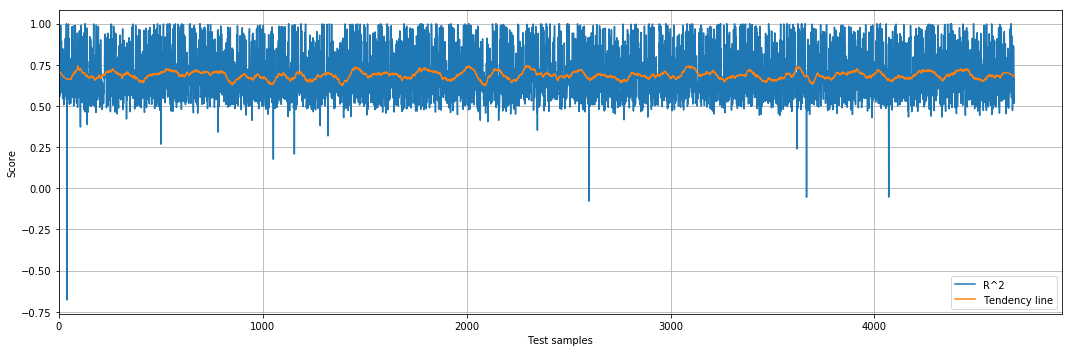

time: 519 ms


In [0]:
tendency = savgol_filter(score, 111, 2)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(score)), score, label="R^2")
plt.plot(np.arange(len(score)), tendency, label="Tendency line")
plt.xlim(0)
plt.xlabel("Test samples")
plt.ylabel("Score")
plt.grid()
plt.legend()

plt.tight_layout()

As shown above, the model strugles to generalise, which indicates that to accurately estimate the FWI value, it is required to take into consideration the temporal dynamics of each variable.

# Conclusion and future work

To determine the nonlinear dependencies between BUI, ISI, and FWI of different geographical locations, an online learning SVM model based on Stochastic Gradient Descent was employed. The proposed approach focused on capturing the *geographical* interdependencies, instead of the temporal ones. Results have shown that although nonlinear relationships between features (BUI, ISI) and label (FWI) exist, the proposed approach is not the most adequate since the model's performance greatly varies overtime, presenting an aggregate average performance socre of 63%. A future implementation would benefit from focusing on the temporal dynamics of each variable. In such situation, it would be possible not only to predict the future values of each variable, but also to gain important insights on their relationship dynamics, over time.